In [ ]:
from google.colab import drive
drive.mount('/googledrive', force_remount=True)


In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger 
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


%matplotlib inline
import matplotlib.pyplot as plt

# !pip install livelossplot 
from livelossplot import PlotLossesKeras


from keras import backend

from keras.layers import AveragePooling1D, Input, GlobalMaxPooling1D
from keras import layers, models
from keras import backend

        
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

Using TensorFlow backend.


# Data

## Load Data set 

(24000, 500) (24000,)


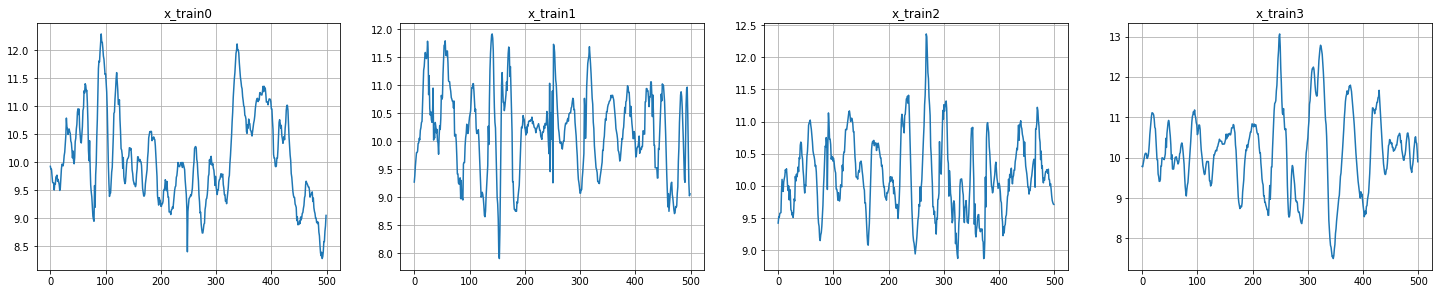

In [10]:
# data_set_path = './data_set/my_data/class_9'
data_set_path = './data_set/svm/'

save_path = './save_file/data_6_500_hard_svm'

x_data = np.load(data_set_path+"/x_data_6_500_hard_svm_acc+gyro.npy")
y_data = np.load(data_set_path+"/y_data_6_500_hard_svm_acc+gyro.npy")
print(x_data.shape, y_data.shape)

data_classes = 6

# # Normalization
# for idx in range(len(x_data)):
#     min = np.min(x_data[idx])
#     max = np.max(x_data[idx])
#     x_data[idx] = (x_data[idx] - min) / (max - min)

# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

# # Standardize
# for idx in range(len(x_data)):
#     standard_deviation = np.std(x_data[idx])
#     mean = np.mean(x_data[idx])
#     x_data[idx] = (x_data[idx] - mean) / standard_deviation


# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

fig = plt.figure(figsize=(25,10))

for id in range(4):
    ax = fig.add_subplot(2,4,id+1)
    ax.plot(x_data[id])
    ax.grid(True)
    ax.set_title(f"x_train{id}")



## Data Augmentation

In [3]:

class TimeSeriesDataAugmentation:

    # def __init__(self):
        # self.sigma = 0.05

    def DA_Jitter(self, X, sigma=0.05):
        myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
        return X+myNoise

    def DA_Scaling(self, X, sigma=0.1):
        scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1)) # shape=(1,3)
        myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
        return X*myNoise


    def GenerateRandomCurves(self, X, sigma=0.2, knot=4):
        
        xx = np.arange(0, X.shape[0], (X.shape[0]-1) / (knot + 1)) #(3,1) * (1, 6) = (3,6) // (6,3)

        yy = np.random.normal(loc = 1.0, scale = sigma, size = (knot + 2)) # (6, 3)
        x_range = np.arange(X.shape[0])

        cs_x = CubicSpline(xx, yy)

        return np.array(cs_x(x_range))


    def DA_MagWarp(self, X, sigma=0.2):
        return X * self.GenerateRandomCurves(X, sigma)



    def DistortTimesteps(self, X, sigma=0.2, knot=4):
        tt = self.GenerateRandomCurves(X, sigma, knot) # Regard these samples aroun 1 as time intervals
        tt_cum = np.cumsum(tt)        # Add intervals to make a cumulative graph
        t_scale = (X.shape[0]-1) / tt_cum[-1] 

        tt_cum = tt_cum * t_scale

        return tt_cum



    def DA_TimeWarp(self, X, sigma=0.2):
        tt_new = self.DistortTimesteps(X, sigma)

        X_new = np.zeros(X.shape) #(3600, 3)      0

        x_range = np.arange(X.shape[0]) #(3600,)  0~3599

        X_new = np.interp(x_range, tt_new, X)

        return X_new



    def DA_Permutation(self, X, nPerm=4, minSegLength=10):
        data = X
        X_new = np.zeros(data.shape)     #(100,)
        idx = np.random.permutation(nPerm) 

        bWhile = True
        while bWhile == True:
            segs = np.zeros(nPerm+1, dtype=int)
            
            segs[1:-1] = np.sort(np.random.randint(minSegLength, data.shape[0]-minSegLength, nPerm-1))
            segs[-1] = data.shape[0]

            if np.min(segs[1:] - segs[0:-1]) > minSegLength:
                bWhile = False

        pp = 0
        for ii in range(nPerm):
            x_temp = data[segs[idx[ii]]:segs[idx[ii]+1]]
            X_new[pp:pp+len(x_temp)] = x_temp
            pp += len(x_temp)

        return X_new




    def DA_Permutation(self, X, nPerm=4, minSegLength=10):
        data = X
        X_new = np.zeros(data.shape)     #(100,)
        idx = np.random.permutation(nPerm) 

        bWhile = True
        while bWhile == True:
            segs = np.zeros(nPerm+1, dtype=int)
            
            segs[1:-1] = np.sort(np.random.randint(minSegLength, data.shape[0]-minSegLength, nPerm-1))
            segs[-1] = data.shape[0]

            if np.min(segs[1:] - segs[0:-1]) > minSegLength:
                bWhile = False

        pp = 0
        for ii in range(nPerm):
            x_temp = data[segs[idx[ii]]:segs[idx[ii]+1]]
            X_new[pp:pp+len(x_temp)] = x_temp
            pp += len(x_temp)

        return X_new

    

## Data split

In [ ]:

#data_set_구분
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, shuffle=False)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#y_data onehot encoding
y_train = keras.utils.to_categorical(y_train, data_classes)
y_test = keras.utils.to_categorical(y_test, data_classes)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

## Data packaging

In [ ]:
isPerdata = True
# isPerdata = False

if not isPerdata:
    x_train = x_train.reshape(-1, 100)
    x_test  = x_test.reshape(-1, 100)
    y_train = y_train.reshape(-1, 9)
    y_test = y_test.reshape(-1, 9)
else:
    # x_train = x_train.reshape(-1, 1, 100)
    # x_test  = x_test.reshape(-1, 1, 100)
#     y_train = y_train.reshape(-1, 1, 9)
#     y_test = y_test.reshape(-1, 1, 9)
    x_train = x_train.reshape(-1, 100,1)
    x_test  = x_test.reshape(-1, 100,1)
    # y_train = y_train.reshape(-1, 9)
    # y_test = y_test.reshape(-1, 9)


# x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# k fold cross validation

In [12]:
#y_data onehot encoding
y = keras.utils.to_categorical(y_data, data_classes)
x = x_data.reshape(-1, 500,1)

print(x.shape, y.shape)

(24000, 500, 1) (24000, 6)


In [5]:

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall



# Model

In [6]:
def dense_block(x, blocks, growth_rate, name):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def conv_block(x, growth_rate, name):
    bn_axis = 2
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)

    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)

    x1 = layers.Conv1D(4 * growth_rate, 1, use_bias=True, kernel_initializer='he_normal', name=name + '_1_conv')(x1)

    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)

    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)

    x1 = layers.Conv1D(growth_rate, 3, padding='same', use_bias=True, kernel_initializer='he_normal', name=name + '_2_conv')(x1)

    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])

    # x = layers.Conv1D(growth_rate, 1, padding='same', use_bias=False, name=name + '_3_conv')(x)
    # x = layers.Add(name=name + '_concat')([x, x1])

    
    return x



def transition_block(x, reduction, name):
    bn_axis = 2
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)

    x = layers.Activation('relu', name=name + '_relu')(x)

    x = layers.Conv1D(int(backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, kernel_initializer='he_normal', name=name + '_conv')(x)
                      
#     x = layers.AveragePooling1D(2, strides=2, name=name + '_pool')(x)
    x = layers.MaxPooling1D(2, strides=2, name=name + '_pool')(x)

    # x = spatial_pyramid_pool(x, 3, bn_axis, name)
    
    return x


In [7]:
from keras.engine.topology import Layer
import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[2]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        num_rows = input_shape[1]
        # num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        # col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]


        outputs = []


        for pool_num, num_pool_regions in enumerate(self.pool_list):
            for jy in range(num_pool_regions):
                # for ix in range(num_pool_regions):
                #     x1 = ix * col_length[pool_num]
                #     x2 = ix * col_length[pool_num] + col_length[pool_num]
                    y1 = jy * row_length[pool_num]
                    y2 = jy * row_length[pool_num] + row_length[pool_num]

                    # x1 = K.cast(K.round(x1), 'int32')
                    # x2 = K.cast(K.round(x2), 'int32')
                    y1 = K.cast(K.round(y1), 'int32')
                    y2 = K.cast(K.round(y2), 'int32')

                    # new_shape = [input_shape[0], y2 - y1,
                    #                 x2 - x1, input_shape[3]]

                    new_shape = [input_shape[0], y2 - y1, input_shape[2]]


                    x_crop = x[:, y1:y2, :]
                    xm = K.reshape(x_crop, new_shape)
#                     pooled_val = K.max(xm, axis=1)
                    pooled_val = K.mean(xm, axis=1)
                    outputs.append(pooled_val)

        #outputs = K.concatenate(outputs,axis = 1)
        outputs = K.concatenate(outputs)
        #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
        #outputs = K.permute_dimensions(outputs,(3,1,0,2))
        #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

# version 3

In [14]:
def DcnnNetv3(depth=None,
            growthRate = None,
            include_top = None,
            input_tensor = None,
            input_shape = None,            
            pooling = None,
            classes = None,
            **kwargs):
    


    if type(depth) is list:
        if len(depth) == 4:
            blocks = depth
            depth = sum(blocks) * 2 + 5
        else:
            assert True, "custom depth length is 4"
    else:
        if depth == 121:
            blocks = [6, 12, 24, 16]
        elif depth == 169:
            blocks = [6, 12, 32, 32]
        elif depth == 201:
            blocks = [6, 12, 48, 32]
        elif depth == 161:
            blocks = [6, 12, 36, 24]
        else:
            print(f'{depth} is not allowed depth, you will use custom_blocks parameter')


    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    nChannels = 2 * growthRate
    bn_axis = 2


    x = layers.ZeroPadding1D(padding=3)(img_input)
    x = layers.Conv1D(nChannels, 7, strides=1, use_bias=True, name='conv1/conv')(x)

#     x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
#     x = layers.Activation('relu', name='conv1/relu')(x)

#     x = layers.ZeroPadding1D(padding=1)(x)
#     x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)
    
    

    # [6, 12, 48, 32]
    x = dense_block(x, blocks[0], growthRate, name='conv2')
    x = transition_block(x, 0.5, name='pool2')

    x = dense_block(x, blocks[1], growthRate, name='conv3')
    x = transition_block(x, 0.5, name='pool3')

    x = dense_block(x, blocks[2], growthRate, name='conv4')
    x = transition_block(x, 0.5, name='pool4')

    x = dense_block(x, blocks[3], growthRate, name='conv5')

    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    
##################################################


# FCN Classification block
#     x = layers.MaxPooling1D(2, strides=2, name='max_pool')(x)
#     x = layers.Conv1D(4096,6, strides=1, activation='relu',name='fc1',padding='valid')(x)
#     x = layers.Conv1D(1440,12, strides=1, activation='relu',name='fc2',padding='valid')(x)
#     x = layers.Conv1D(9, 1, strides=1,activation='softmax',name='predictions',padding='valid')(x)

################################################
    
#     x = SpatialPyramidPooling([1,2,4], name='spp')(x)

    if include_top:
#         # !!!!!
        x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc')(x)
#     else:
#         if pooling == 'avg':
#             x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
#         elif pooling == 'max':
#             x = layers.GlobalMaxPooling1D(name='max_pool')(x)


    model = models.Model(img_input, x, name=f'densenet{depth}')

    return model




def createModel():
    inputs = layers.Input(shape=(500, 1))

    modelv3 = DcnnNetv3(depth=201, growthRate=24, include_top=True, 
                        input_tensor=inputs, pooling='max', classes=data_classes)
    modelv3.summary()
    modelv3.name
    return modelv3

# traning

In [15]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False
history = []


def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])



# modelv3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                          f1_m, recall_m, precision_m])



from sklearn.model_selection import StratifiedKFold
# Instantiate the cross validator

skf = StratifiedKFold(n_splits=5, shuffle=True)
# Loop through the indices the split() method returns

for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    
    model = None
    model = createModel()
    
    csv_logger_path = save_path+f'/{model.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, csv_logger]

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                               f1_m, recall_m, precision_m,
                                                                single_class_precision(0), single_class_recall(0),
                                                                single_class_precision(1), single_class_recall(1),
                                                                single_class_precision(2), single_class_recall(2),
                                                                single_class_precision(3), single_class_recall(3),
                                                                single_class_precision(4), single_class_recall(4),
                                                                single_class_precision(5), single_class_recall(5),
                                                                single_class_precision(6), single_class_recall(6),
                                                                single_class_precision(7), single_class_recall(7),
                                                                single_class_precision(8), single_class_recall(8)]) 
    
    
    history.append(model.fit(xtrain, ytrain, 
                        epochs=300, batch_size=batch_size, 
                        shuffle=fit_shuffle,
#                         workers=4, 
                        validation_data=(xval, yval),
                        callbacks=callbacks))



# # 4. 모델 학습시키기
# history = modelv3.fit(x_train, y_train, 
#                     epochs=300, batch_size=batch_size, 
#                     shuffle=fit_shuffle,
# #                     workers=1, 
#                       validation_data=(x_test, y_test),
#                     callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
# evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



epoch:  0
Learning rate:  0.01
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500, 1)       0                                            
__________________________________________________________________________________________________
zero_padding1d_3 (ZeroPadding1D (None, 506, 1)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv1D)             (None, 500, 48)      384         zero_padding1d_3[0][0]           
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 500, 48)      192         conv1/conv[0][0]                 
______________________________________________________________________________

Train on 19200 samples, validate on 4800 samples
Epoch 1/300
epoch:  0
Learning rate:  0.01


ResourceExhaustedError: OOM when allocating tensor with shape[64,984,1,125] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_1/SGD/gradients/conv4_block34_1_conv_2/convolution/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv4_block34_1_conv_2/convolution/ExpandDims, PermConstNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_2/acc/Mean/_21337 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_91159_metrics_2/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:

evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


# version 1

In [ ]:

# inputs = Input(shape=(100, 1))

# modelv1 = DcnnNetv1(depth=100, growthRate=32, include_top=True, input_tensor=inputs, pooling='avg', classes=9)
# modelv1.summary()
# modelv1.name


# v1 training

In [ ]:
if not os.path.isdir(save_path):
    os.mkdir(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2
split_shuffle = False

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


# models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                                     single_class_precision(0), single_class_recall(0),
#                                                                                     single_class_precision(1), single_class_recall(1),
#                                                                                     single_class_precision(2), single_class_recall(2),
#                                                                                     single_class_precision(3), single_class_recall(3),
#                                                                                     single_class_precision(4), single_class_recall(4),
#                                                                                     single_class_precision(5), single_class_recall(5),
#                                                                                     single_class_precision(3), single_class_recall(6),
#                                                                                     single_class_precision(4), single_class_recall(7),
#                                                                                     single_class_precision(5), single_class_recall(8)])

modelv1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

csv_logger_path = save_path+f'/{modelv1.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
if not os.path.isdir(os.path.dirname(csv_logger_path)):
    os.makedirs(os.path.dirname(csv_logger_path))
csv_logger = CSVLogger(csv_logger_path, append=True)

lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

callbacks = [lr_scheduler, csv_logger]





# 4. 모델 학습시키기
history = modelv1.fit(x_train, y_train, 
                                        epochs=300, batch_size=batch_size, 
                                        shuffle=fit_shuffle,
                                        workers=4, validation_data=(x_test, y_test),
                                        callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
evaluate = modelv1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
# 6. 모델 평가하기
evaluate = modelv1.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print(evaluate)

# version2

In [ ]:
inputs = Input(shape=(100, 1))

modelv2 = DcnnNetv2(depth=201, growthRate=32, include_top=True, input_tensor=inputs, pooling='avg', classes=9)
modelv2.summary()
modelv2.name

# version2 Training

In [ ]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


# models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                                     single_class_precision(0), single_class_recall(0),
#                                                                                     single_class_precision(1), single_class_recall(1),
#                                                                                     single_class_precision(2), single_class_recall(2),
#                                                                                     single_class_precision(3), single_class_recall(3),
#                                                                                     single_class_precision(4), single_class_recall(4),
#                                                                                     single_class_precision(5), single_class_recall(5),
#                                                                                     single_class_precision(3), single_class_recall(6),
#                                                                                     single_class_precision(4), single_class_recall(7),
#                                                                                     single_class_precision(5), single_class_recall(8)])

modelv2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                                         f1_m, recall_m, precision_m])

csv_logger_path = save_path+f'/{modelv2.name}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
if not os.path.isdir(os.path.dirname(csv_logger_path)):
    os.makedirs(os.path.dirname(csv_logger_path))
csv_logger = CSVLogger(csv_logger_path, append=True)

lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

callbacks = [lr_scheduler, csv_logger]





# 4. 모델 학습시키기
history = modelv2.fit(x_train, y_train, 
                    epochs=300, batch_size=batch_size, 
                    shuffle=fit_shuffle,
#                     workers=1, 
                      validation_data=(x_test, y_test),
                    callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
evaluate = modelv2.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
evaluate = modelv2.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


In [ ]:
epoch:  0
Learning rate:  0.01
Train on 2268 samples, validate on 972 samples
Epoch 1/300
epoch:  0
Learning rate:  0.01
2268/2268 [==============================] - 110s 48ms/step - loss: 0.5774 - acc: 0.7743 - f1_m: 0.7240 - recall_m: 0.6958 - precision_m: 0.7823 - val_loss: 8.3245 - val_acc: 0.3313 - val_f1_m: 0.3313 - val_recall_m: 0.3313 - val_precision_m: 0.3313
Epoch 2/300
epoch:  1
Learning rate:  0.01
2268/2268 [==============================] - 14s 6ms/step - loss: 0.1662 - acc: 0.9374 - f1_m: 0.9380 - recall_m: 0.9361 - precision_m: 0.9399 - val_loss: 0.8003 - val_acc: 0.7840 - val_f1_m: 0.7828 - val_recall_m: 0.7809 - val_precision_m: 0.7848
Epoch 3/300
epoch:  2
Learning rate:  0.01
2268/2268 [==============================] - 15s 7ms/step - loss: 0.1239 - acc: 0.9612 - f1_m: 0.9616 - recall_m: 0.9603 - precision_m: 0.9628 - val_loss: 5.2734 - val_acc: 0.3539 - val_f1_m: 0.3538 - val_recall_m: 0.3313 - val_precision_m: 0.3803
Epoch 4/300
epoch:  3
Learning rate:  0.01
 832/2268 [==========>...................] - ETA: 8s - loss: 0.1580 - acc: 0.9363 - f1_m: 0.9380 - recall_m: 0.9303 - precision_m: 0.9462

# version 3

In [ ]:
img_input = layers.Input(shape=input_shape)

nChannels = 2 * growthRate
bn_axis = 2

x = layers.ZeroPadding1D(padding=1)(img_input)
x = layers.Conv1D(nChannels, 3, strides=1, use_bias=False, name='conv1/conv')(x)


# 실험 결과

## version1

depth = 100

### concatenate
```
start lr = 0.01
    972/972 [==============================] - 1s 975us/step
    [0.26581049285380653, 0.9259259259259259]

start lr = 0.1
    972/972 [==============================] - 1s 976us/step
    [0.43105335702636727, 0.9176954732510288]
```


### add

```
start lr = 0.01
    972/972 [==============================] - 1s 520us/step
    [0.3993826474181909, 0.8713991769547325]

start lr = 0.1

학습되지 않음
```

## version 2

201 layer

### concatenate

```
start lr = 0.1
    972/972 [==============================] - 1s 1ms/step
    [0.5396262257064811, 0.8446502060066035]
Data normalization
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [2.230289366755466, 0.6306584359687052, 0.6331204848034392, 0.6255144030468944, 0.6410546889030394]
min-max normalization
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [2.013901627603382, 0.6707818932494019, 0.6677523871017582, 0.6615226339901426, 0.674254747329916]

start lr = 0.01
    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [0.5466709941502952, 0.8631687245251219, 0.8630309512095197, 0.8621399179407598, 0.8639362478943028]

```


```python 
start lr = 0.01
x = layers.ZeroPadding1D(padding=3)(img_input)
x = layers.Conv1D(nChannels, 7, strides=1, use_bias=False, name='conv1/conv')(x)

# x = layers.BatchNormalization(
#     axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
# x = layers.Activation('relu', name='conv1/relu')(x)

# x = layers.ZeroPadding1D(padding=1)(x)
# x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)

    972/972 [==============================] - 2s 2ms/step
    loss     acc      f1      recall      precision
    [0.22257122489547493, 0.9454732510288066, 0.9459430514049137, 0.9454732510288066, 0.9464204066084245]

x = layers.ZeroPadding1D(padding=3)(img_input)
x = layers.Conv1D(nChannels, 7, strides=2, use_bias=False, name='conv1/conv')(x)

# x = layers.BatchNormalization(
#     axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
# x = layers.Activation('relu', name='conv1/relu')(x)

# x = layers.ZeroPadding1D(padding=1)(x)
# x = layers.MaxPooling1D(3, strides=2, name='pool1')(x)

    972/972 [==============================] - 1s 1ms/step
    loss     acc      f1      recall      precision
    [0.5289181569809623, 0.8837448559670782, 0.8851272049264162, 0.8816872427983539, 0.8886497324876824]

```

### add

```
start lr = 0.01
    972/972 [==============================] - 1s 923us/step
    [0.8464200724790125, 0.7129629632082496]


start lr = 0.1
    972/972 [==============================] - 1s 915us/step
    [1.0798768680772663, 0.49074074074074076]
```




In [ ]:

if not os.path.isdir(save_path):
    os.mkdir(save_path)

params = {
    'batch_size' : [2, 4, 8, 16, 32, 64, 128, 256],
    'fit_shuffle' : [False, True],
    'split_shuffle' : [False, True],
    'start_lr' : [1e-1, 1e-2, 1e-3],
    'optimizer' : ['sgd','adam','nAdam'],
    'split_val' : [0.2, 0.3, 0.4]
}

batch_size = params['batch_size'][0]
fit_shuffle = params['fit_shuffle'][0]
split_shuffle = params['split_shuffle'][0]
start_lr = params['start_lr'][0]
optimizer = params['optimizer'][0]
split_val = params['split_val'][0]




In [ ]:
from keras.models import Sequential #스택형 모델
from keras.models import Model #함수형 모델

from keras.layers import Dense, Embedding, LSTM, Input
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

In [ ]:
from keras import backend as K

# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall


In [ ]:
models = {}

model_type = {
    "MLP" : {},
    "LSTM" : {},
    "CONV1D" : {},
    "CONV1D+LSTM" : {},
    "LSTM+CONV1D" : {}
}

histories = {}
evaluates = {}



#MLP


In [ ]:

for ii in range(6):
    iii = 0
    inputs = Input(shape=(1, 100))
    x = Dense(10, activation='relu')(inputs)
    for iii in range(ii):
        x = Dense(10, activation='relu')(x)
    y = Dense(9, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=y)
    models[f"[MLP]{ii+1}_layer"] = model


#LSTM

In [ ]:

for ii in range(6):
    iii = 0
    inputs = Input(shape=(1,100))
    x = LSTM(10, return_sequences=True, activation="relu")(inputs)
    for iii in range(ii):
        if iii != ii - 1:
            x = LSTM(10, return_sequences=True, activation="relu")(x)
        else:
            x = LSTM(10, return_sequences=True, activation="relu")(x)
    y = Dense(6, activation="softmax")(x)

    models[f"[LSTM]{ii+1}_layer"] = Model(inputs=inputs, outputs=y)

#Conv1D

In [ ]:

for ii in range(6):
    inputs = Input(shape=(1,100))
    x = Conv1D(10, 1, activation="relu", padding="same", strides=1)(inputs)
    for iii in range(ii):
        x = Conv1D(100, 3, activation="relu", padding="same", strides=1)(x)
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[Conv1D]{ii+1}_layer"] = model




#Conv1D + LSTM

In [ ]:
for ii in range(6):
    inputs = Input(shape=(1,100))
    x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(inputs)
    x = LSTM(10, activation="relu", return_sequences=True)(x)
    for iii in range(ii):
        x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
        x = LSTM(10, activation="relu", return_sequences=True)(x)  
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[Conv1D + LSTM]{ii+1}_layer"] = model


#LSTM + Conv1D

In [ ]:
 for ii in range(6):
    inputs = Input(shape=(1,100))
    x = LSTM(10, activation="relu", return_sequences=True)(inputs)
    x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
    for iii in range(ii):
        x = LSTM(10, activation="relu", return_sequences=True)(x)  
        x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
    y = Dense(9, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    models[f"[LSTM + Conv1D]{ii+1}_layer"] = model


In [ ]:
models

In [ ]:
for model in models:
    print(model)
    models[model].summary()

In [ ]:


for model in models:

    def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr

    # 3. 모델 학습과정 설정하기
    if optimizer == 'sgd':
        sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)
    elif optimizer == 'adam':
        adam = Adam(lr=lr_schedule(0))
    elif optimizer == 'nAdam':
        nAdam = Nadam(lr=lr_schedule(0))


    # model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


    # models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
    #                                                                                     single_class_precision(0), single_class_recall(0),
    #                                                                                     single_class_precision(1), single_class_recall(1),
    #                                                                                     single_class_precision(2), single_class_recall(2),
    #                                                                                     single_class_precision(3), single_class_recall(3),
    #                                                                                     single_class_precision(4), single_class_recall(4),
    #                                                                                     single_class_precision(5), single_class_recall(5),
    #                                                                                     single_class_precision(3), single_class_recall(6),
    #                                                                                     single_class_precision(4), single_class_recall(7),
    #                                                                                     single_class_precision(5), single_class_recall(8)])

    models[model].compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    csv_logger_path = save_path+f'/{model}(batch_size={batch_size}, split_val={split_val}, fit_shuffle={fit_shuffle}, split_shuffle={split_shuffle}, optimizer={optimizer}, lr=s:{start_lr}, per:1e-1, e:(150, 225))_log.csv'
    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, csv_logger]





    # 4. 모델 학습시키기
    histories[model] = models[model].fit(x_train, y_train, 
                                         epochs=300, batch_size=batch_size, 
                                         shuffle=fit_shuffle,
                                         workers=4, validation_data=(x_test, y_test),
                                         callbacks=callbacks)
    
    # histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

    # 6. 모델 평가하기
    evaluates[model] = models[model].evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



In [ ]:
evaluates

In [ ]:
# 5. 학습과정 살펴보기

for history in histories:
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(1,2,1)
    ax.plot(histories[history].history['loss'], 'y', label="train loss")
    ax.plot(histories[history].history['val_loss'], 'r', label=f"val loss({format(evaluates[history][0], '0.4f')})")
    ax.set_ylabel('loss')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{history}")

    ax = fig.add_subplot(1,2,2)
    ax.plot(histories[history].history['acc'], 'y', label="train acc")
    ax.plot(histories[history].history['val_acc'], 'r', label=f"val acc({format(evaluates[history][1],'0.4f')})")
    ax.set_ylabel('accuray')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{history}")

    save_type = "history"
    history_path = f"{save_path}/{save_type}"

    if not os.path.isdir(history_path):
        os.mkdir(history_path)
    plt.savefig(history_path + "/" + history)

    

In [ ]:
*histories['[MLP]1_layer'].history[1]

In [ ]:
for history in histories:

    precs = [x for x in histories[history].history.keys() if "prec" in x if "val" not in x]
    recalls = [x for x in histories[history].history.keys() if "recall" in x if "val" not in x]

    val_precs = [x for x in histories[history].history.keys() if "prec" in x if "val" in x]
    val_recalls = [x for x in histories[history].history.keys() if "recall" in x if "val" in x]

    fig = plt.figure(figsize=(30,5))

    for prec in precs:
        ax = fig.add_subplot(1,4,1)
        ax.plot(histories[history].history[prec], label=prec)
        ax.set_xlabel('epoch')
        ax.set_ylabel('precision')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")
        ax.set_ylim(0, 1.0)
        
    for recall in recalls:
        ax = fig.add_subplot(1,4,2)
        ax.plot(histories[history].history[recall], label=recall)
        ax.set_xlabel('epoch')
        ax.set_ylabel('recall')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")  
        ax.set_ylim(0, 1.0)

    for prec in val_precs:
        ax = fig.add_subplot(1,4,3)
        ax.plot(histories[history].history[prec], label=prec)
        ax.set_xlabel('epoch')
        ax.set_ylabel('val_precision')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")
        ax.set_ylim(0, 1.0)
        
    for recall in val_recalls:
        ax = fig.add_subplot(1,4,4)
        ax.plot(histories[history].history[recall], label=recall)
        ax.set_xlabel('epoch')
        ax.set_ylabel('val_recall')
        ax.grid(True)
        ax.legend()
        ax.set_title(f"{history}")  
        ax.set_ylim(0, 1.0)

    save_type = "precision,recall"
    history_path = f"{save_path}/{save_type}"

    if not os.path.isdir(history_path):
        os.mkdir(history_path)
    plt.savefig(history_path + "/" + history)


In [ ]:
fig = plt.figure(figsize=(15,7))

for id, evaluate in enumerate(evaluates):
    # print(evaluates[evaluate])
    # print(evaluates[evaluate][2:])
    metrics = np.array(evaluates[evaluate][2:])

    idx = np.linspace(0, 11, 12) 
    # print(idx)
    precision = metrics[(idx % 2) == 0]
    recall = metrics[((idx+1) % 2) == 0]

    # print(precision)
    # print(recall)
    # print("\n")
    # print("\n")
    # print("\n")
    # print("\n")


    N = 6
    ind = np.arange(N)
    width = 0.35
    
    ax = fig.add_subplot(2,3,id+1)

    # fig, ax = plt.subplots()
    prec_bar = ax.bar(ind, precision, width, color='r')
    recall_bar = ax.bar(ind + width, recall, width, color='y')

    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('C1', 'C2', 'C3', 'C4', 'C5', 'C6'))

    ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))
    # ax.grid(True)
    ax.set_title(evaluate)
    ax.set_ylim(0,1.0)

        
save_type = "precision,recall_graph"
history_path = f"{save_path}/{save_type}"

if not os.path.isdir(history_path):
    os.mkdir(history_path)
plt.savefig(history_path + "/" + evaluate)


In [ ]:
``

In [ ]:
x_train = x_train.reshape(-1, 1, 100)
x_test  = x_test.reshape(-1, 1, 100)
y_train = y_train.reshape(-1,  6)
y_test = y_test.reshape(-1, 6)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
inputs = Input(shape=(1,100))
x = LSTM(10, return_sequences=True, activation="relu")(inputs)
y = Dense(6, activation="softmax")(x)
model = Model(inputs=inputs, outputs=y)


model.summary()


In [ ]:
# 2. 모델 구성하기
# model = Sequential()
# model.add(LSTM(128))
# # model.add(Flatten())
# model.add(Dense(6, activation='softmax'))


models = {}
histories = {}
evaluates = {}





for model in models:
    print(model)
    models[model].summary()

In [ ]:
inputs = Input(shape=(1,100))
x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(inputs)
x = LSTM(10, activation="relu",return_sequences=True)(x)
x = Conv1D(10, 1, activation="relu", padding="valid", strides=1)(x)
x = LSTM(10, activation="relu")(x)  
y = Dense(6, activation='softmax')(x)
model = Model(inputs=inputs, outputs=y)
model.summary()

In [ ]:


models = {}
histories = {}
evaluates = {}






for model in models:
    print("\n"+model)
    models[model].summary()
# model.add(Conv1D(50,
#                  1,
#                  input_shape=(1,100),
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# # model.add(GlobalMaxPooling1D())
# model.add(LSTM(50))
# model.add(Dense(6, activation='softmax'))

# model.summary()

In [ ]:


# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_ylabel('accuray')
ax.grid(True)
ax.legend()



# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 3.0])

# acc_ax.plot(hist.history['acc'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:
model = Sequential()
model.add(Conv1D(50,
                 1,
                 input_shape=(1,100),
                 padding='valid',
                 activation='relu',
                 strides=1))
# model.add(GlobalMaxPooling1D())
model.add(LSTM(50))
model.add(Dense(6, activation='softmax'))

model.summary()

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:

model = Sequential([
                    # Input(shape=(1,100)),
                    Conv1D(50,1, input_shape=(1,100) ,padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    Conv1D(50,1, padding='valid',activation='relu',strides=1),
                    GlobalMaxPooling1D(),
                    Dense(50, activation='relu'),
                    # model.add(Dropout(0.2))
                    Dense(6, activation='softmax')

])

model.summary()


In [ ]:
# model = Sequential()

# # model.add(Embedding(10, 128, input_length=100))
# # model.add(Dropout(0.2))
# model.add(Input(shape=(1,100)))
# model.add(Conv1D(100,
#                  1,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(6, activation='softmax'))



# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.set_ylabel('loss')
ax.grid(True)
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_ylabel('accuray')
ax.grid(True)
ax.legend()




# fig, loss_ax = plt.subplots()

# acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 3.0])

# acc_ax.plot(hist.history['acc'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)